# Automatic transcription of interviews using vosk

Summary:
1. Generate the transcripts of audio files
2. Evaluation of the transcripts generated
3. Influence of the buffer size on the word error rate

In this notebook we explain how we used and evaluated a vosk autoatic speech recognition model for the transcription of spontaneous speech in four recorded interviews. In each interview, there are 2 people in the conservations (an interviewer asking questions, and a person being interviewed answering). For each interview, we have at our disposal an audio file of the recorded interview and a hand written transcript of the interview. For a matter of time we only analysed the transcription of the first 12 minutes of each interview.

## 1. Generate the transcripts of audio files

This part of the notebook is to explain how the automated transcription of the audio files of the interviews was done using the vosk-API.

The audio files being quite long we transcribed only the first 12 minutes of each audio file. The audio files used are:
- Alexis.m4a
- Caitlyn.m4a
- Clément1.m4a
- Clément2.m4a

Fist the audio files are converted to .wav Mono PCM format using the `ConvertToWav.py`. We get the following files which we saved in a seperate corpus_wav file (not on github because takes too much memory):
- alexis.wav
- caitlyn.wav
- clement1.wav
- clement2.wav

We can check the parameters of one of these wave files with the `getparams()` method:

In [1]:
import wave

wf_caitlyn = wave.open("corpus_wav/caitlyn.wav")
wf_caitlyn.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=216603648, comptype='NONE', compname='not compressed')

Note that `nchanels=1` so we do have Mono format. The total number of frames is `nframes=216603648` with a `framerate=32000` so we have about $ {\textrm{nframes} \over{\textrm{framerate}}} = 6769 \textrm{s} = 1\textrm{h}53$ of audio time for Caitlyn. The automatic speek recognition vosk model can take some time to run depending on the machine performance, in our case a bit shorter than the duration of the audio file played in norlmal speed (1h53). So we only transcribe the first 12 minutes of audio for the 4 files we have.

For this, we run the automatic transcription with vosk api (see [https://github.com/alphacep/vosk-api](https://github.com/alphacep/vosk-api)). We use the French ASR vosk model LinTO (1.4 GB) which can be downloaded at [https://alphacephei.com/vosk/models](https://alphacephei.com/vosk/models).

The `transcribe()` function takes as argument the wav file to be transcribed and returns the outputs of the vosk model: a dictionnary with the transcription for each words (or sometimes group of words), the start and end time of each word, the confidence level of the transcription, as well as the whole text transcribed.

In the `transcribe()` function, at each iteration, the vosk model takes as input a buffer of bytes encoding the audio file. Once it has enough bytes to transcribe a word it adds it to its output dictionary.

Therefore we need to chose a buffer size that we pass in the vosk model at each iteration. We tried different buffer sizes (going from 1 frame to the total number of frames in 12 minutes) and noticed that it only has a small impact on the transcription. The WER does not depend a lot on the buffer size (see part **3.** of the notebook for more details). We chose `buffer_size=32000` which is equal to the frame rate, so it corresponds to 1 second of audio file.

In [2]:
import wave
import json
import time
import vosk
from vosk import Model, KaldiRecognizer, SetLogLevel

# We load the vosk model. This takes a few seconds.
model = vosk.Model("vosk-model-fr-0.6-linto")
SetLogLevel(0)  # To control how much output we want

nb_sec = 720  # 12 min

# Function to transcribe an audio file with the vosk model.
def transcribe(file_path, buffer_size=32000, nb_sec=nb_sec):
    start_time = time.time()  # To check the time of transciption
    wf = wave.open(file_path)
    rec = KaldiRecognizer(model, wf.getframerate())
    nb_buffers = wf.getframerate() * nb_sec // buffer_size
    for i in range(nb_buffers):
        # For each iteration readframes() removes the frames already read.
        buffer = wf.readframes(buffer_size)
        rec.AcceptWaveform(buffer)
    result_json_str = rec.FinalResult()
    result = json.loads(result_json_str)
    wf.close()
    end_time = time.time()
    delta_time = end_time - start_time
    return result, delta_time


For each of the 4 audio files we run the `transcribe()` function, print the time it takes for the transcription and save the resuts in the [Transcripts](Transcripts) folder.

In [3]:
# Names to identify each audio file.
list_names = ["alexis",
              "caitlyn",
              "clement1",
              "clement2"]

for name in list_names:
    file_path = "corpus_wav/" + name + ".wav"
    result, delta_time = transcribe(file_path)
    
    print("Transcription time " + name + ": " + str(delta_time) + " s")
    
    # We save the output of the vosk model in a json file.
    with open("trans/vosk_result_" + name + ".json", "w") as outfile:  
        json.dump(result, outfile, indent=4, sort_keys=True)

    # We save the text of the transcript in a seperate .txt file
    with open("trans/vosk_" + name + ".txt", "w") as outfile:  
        outfile.write(result["text"])

Transcription time alexis: 387.3438868522644 s
Transcription time caitlyn: 285.13012981414795 s
Transcription time clement1: 360.4634780883789 s
Transcription time clement2: 301.48654103279114 s


We get the following json files for the output results of the vosk model:
- [vosk_result_alexis.json](Transcripts/vosk_result_alexis.json)
- [vosk_result_caitlyn.json](Transcripts/vosk_result_caitlyn.json)
- [vosk_result_clement1.json](Transcripts/vosk_result_clement1.json)
- [vosk_result_clement2.json](Transcripts/vosk_result_clement2.json)

And the following texts for the transcripts:
- [vosk_alexis.txt](Transcripts/vosk_alexis.txt)
- [vosk_caitlyn.txt](Transcripts/vosk_caitlyn.txt)
- [vosk_clement1.txt](Transcripts/vosk_clement1.txt)
- [vosk_clement2.txt](Transcripts/vosk_clement2.txt)

Here is an extract of the begining of each text file outputed by the vosk model:

In [4]:
for name in list_names:
    with open("Transcripts/vosk_" + name + ".txt", "r") as file:
        print(name + ":" + "\n" + file.read()[:500] + "\n")

alexis:
donc second l'enregistrement est lancé un esprit bien ton accord pour que pour que pour enregistrer au problème donc que je suis avec alexis il est dix-huit heures on est le vingt-cinq juillet battus de sexe masculin tu as vingt-et-un vingt-deux ans vingt-et-un vingt-et-un tu viens de région parisienne de salle de bain merci de yopougon pour le temps accordé à mon intérieur un tapis de te libérer facilement un peu en vacances sur le commencement je finis mon stage de quatre de manu le dix juille

caitlyn:
ok c'est bon j'ai lancé l'enregistrement est-ce que du coup j'ai bien ton accord pour que je sois enregistré oui non qu'est jessie avec kathleen il est quatorze heures vingt-deux le dix-huit août plus de sexe féminin will sawyer est d'accord que fut broches me trompe pas et tu as vingt-deux ans vingt-et-un vingt vingt-deux ans en novembre on y est tu viens de autour de brest région brestoise ouais grosso modo le relecq oui oui c'est ça l'expérience c'est ça a maintenu la mémoi

From reading the beginning of the texts we notice that there are still some errors making the transcript not completely understandable.

## 2. Evaluation of the transcripts generated

In this part of the notebook, we try to compare manual transcripts with the transcripts automatically generated using vosk.

Those transcripts can be found in the [Transcripts](Transcripts/) folder. They are named after the person being interviewed. For each person, only the first 12 minutes of the audio record have been transcribed using vosk. So we have to take into account only the text corresponding to the first 12 minutes of audio in the manual transcripts. To do so, we search manually the last word being said after 12 minutes and take note of total number of caracters from the begining till the end of the last word. We then cut off the rest of the text in the `comparison()` function (see code below for more details).

Transcripts written manually:
- [alexis.docx](Transcripts/alexis.docx)
- [caitlyn.docx](Transcripts/caitlyn.docx)
- [clement1.docx](Transcripts/clement1.docx)
- [clement2.docx](Transcripts/clement2.docx)

Transcripts automatically generated with vosk:
- [vosk_alexis.txt](Transcripts/vosk_alexis.txt)
- [vosk_caitlyn.txt](Transcripts/vosk_caitlyn.txt)
- [vosk_clement1.txt](Transcripts/vosk_clement1.txt)
- [vosk_clement2.txt](Transcripts/vosk_clement2.txt)

When comparing two corresponding texts, the first thing we notice is that the vosk transcripts do not contain any punctuation, capital letters or paragraphs, whereas the human transcripts contains punctuation, some onomatopoeias which are not in the vosk transcripts (such as "humm"), and a special syntax with "#" at the beginning and at the end of some paragraphs to indicate that the interviewer is speaking. Another difference is that the numbers in are written in full letters in the vosk transcripts, and with digits in the human transcript. Of course, in addition to these differences there are some errors of transcription

Those differences complicate the comparison between the transcripts. The best thing to do would be to find a way to automatically add punctuation to the vosk transcripts. But this being quite hard to do, we decided to (automatically) remove the punctuation from the human transcript, remove the "#", the line breaks (marked as "\n"), as well as remove some onomatopeas ("humm") and convert digit numbers to written letters. All this is done in the `remove_punctuation()` function. We get simplified manual transcripts.

Once this is done, the simplified manual transcripts are considered as the ground truth and we compute the word error rate (`'wer'`) for the vosk transcripts in the `comparison()` function.

In [5]:
import jiwer
import docx
import jiwer
import num2words

# get_text() converts the manual transcript docx files to a python string.
def get_text(filename):
    doc = docx.Document(filename)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)  # type: str

def remove_punctuation(text):
    punctuations = ".,?!#:;°"  # punctuation marks to be removed
    clean_txt = ""
    for char in text:
        if char not in punctuations:
            clean_txt += char

    clean_txt = clean_txt.lower()  # Capital letters replaced with lower case
    clean_txt = clean_txt.replace("\xa0", "")  # Remove non-breaking spaces
    clean_txt = clean_txt.replace(" \n ", " ")  # Remove line breaks
    clean_txt = clean_txt.replace("\n", "")
    clean_txt = clean_txt.replace(" humm ", " ")  # Remove "humm"
    clean_txt = clean_txt.replace("’", "'")  # Apostrophe difference (’ vs ')

    # We check each word seperatly to see if it is a number written in digits.
    # If it is a digit number we replace it with the matching number in letters.
    for word in str.split(clean_txt):
        if word.isdigit():
            len_word = len(word)
            number_word = num2words.num2words(int(word), lang='fr')
            pos = clean_txt.find(word)
            clean_txt = clean_txt[:pos] + number_word + clean_txt[pos+len_word:]  

    # num2words doesn't write 21 correctly so we correct it.
    clean_txt = clean_txt.replace("vingt et un", "vingt-et-un")

    return clean_txt

# The names used to identify the 4 pairs of transcripts studied.
list_names = ["alexis", 
              "caitlyn",
              "clement1",
              "clement2"]

# Number of caracters in the manual transcripts corresponding to the first 12 min
# of audio. This has been determined manually.
stop_12_min = {"alexis": 12313, 
               "caitlyn" : 12033,
               "clement1" : 10786,
               "clement2" : 8753}

# We comptute the WER for a vosk transcript and other types of error mesures
# in the comparison() function using the jiwer library.
def comparison(manual_file, vosk_file, nb_caracters):
    text = get_text(manual_file)  # manual transcription
    clean_text = remove_punctuation(text)  # simplified manual transcrition
    clean_text = clean_text[:nb_caracters]  # first 12 minutes in transcript
    with open(vosk_file,'r') as file:
        vosk_text = file.read()  # vosk transcription
    result = jiwer.compute_measures(clean_text, vosk_text)  # computes WER...
    return result

# We compute the errors mesures for all the 4 transcriptions.
error_mesures = {}
for name in list_names:
    manual_file = "Transcripts/" + name + ".docx"
    vosk_file = "Transcripts/vosk_" + name + ".txt"
    nb_caracters = stop_12_min[name]
    error_mesures[name] = comparison(manual_file, vosk_file, nb_caracters)
    
error_mesures

{'alexis': {'wer': 0.36015006252605253,
  'mer': 0.35717238528317485,
  'wil': 0.5027477120564747,
  'wip': 0.4972522879435252,
  'hits': 1555,
  'substitutions': 452,
  'deletions': 392,
  'insertions': 20},
 'caitlyn': {'wer': 0.3766914011348756,
  'mer': 0.3673903788846318,
  'wil': 0.537274685032102,
  'wip': 0.4627253149678981,
  'hits': 1486,
  'substitutions': 539,
  'deletions': 266,
  'insertions': 58},
 'clement1': {'wer': 0.457033125300048,
  'mer': 0.4469483568075117,
  'wil': 0.6246789232756114,
  'wip': 0.3753210767243886,
  'hits': 1178,
  'substitutions': 550,
  'deletions': 355,
  'insertions': 47},
 'clement2': {'wer': 0.4313960455362493,
  'mer': 0.42328042328042326,
  'wil': 0.594222838202449,
  'wip': 0.405777161797551,
  'hits': 981,
  'substitutions': 408,
  'deletions': 280,
  'insertions': 32}}

We save the results in a json file (see [error_mesures.json](Transcripts/error_mesures.json)):

In [6]:
import json

with open("Transcripts/error_mesures.json", "w") as outfile:  
    json.dump(error_mesures, outfile, indent=4, sort_keys=True)

To better read the result we display it as a data frame.

In [7]:
import pandas as pd

pd.DataFrame(error_mesures).round(decimals=2)

,alexis,caitlyn,clement1,clement2
wer,0.36,0.38,0.46,0.43
mer,0.36,0.37,0.45,0.42
wil,0.50,0.54,0.62,0.59
wip,0.50,0.46,0.38,0.41
hits,1555.00,1486.00,1178.00,981.00
substitutions,452.00,539.00,550.00,408.00
deletions,392.00,266.00,355.00,280.00
insertions,20.00,58.00,47.00,32.00


A bar chart to compare the word error rates.

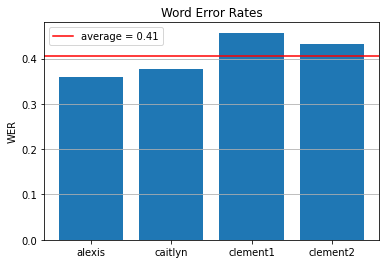

In [8]:
import matplotlib.pyplot as plt
import numpy as np

names = []
wer = []

for name in error_mesures:
    names.append(name)
    wer.append(error_mesures[name]["wer"])
mean_wer = np.mean(wer)

plt.bar(names,wer)
plt.axhline(mean_wer, color="red", label="average = " + str(mean_wer.round(2)))
plt.grid(axis='y')
plt.ylabel("WER")
plt.title("Word Error Rates")
plt.legend()
plt.show()

The WER is around 0.4 which is not so good. When we read the text, we notice indeed that there are still too many errors to really understand what is being said.

In comparison, for the "common voice" corpus the vosk model is claimed to have a wer of 0.16. This can be explained by the fact that in our corpus we have spontaneous speech instead of text that is read (which is the case of the "common voice" corpus).

## 3. Influence of the buffer size on the word error rate

We check that the buffer size used for the vosk transcription does not have a big impact on the WER.

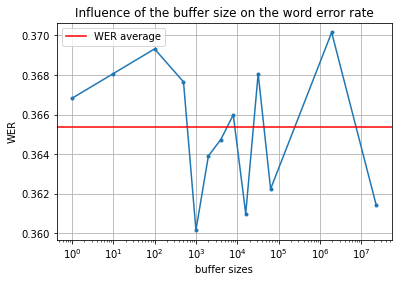

In [9]:
list_buffer_sizes = [1, 10, 100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 
                     32000*2, 32000*60, 32000*720]

# The framerate=32000 so a buffer of size 32000 represents 1 sec of audio.

# Code used to generate the transcripts using different buffer sizes.
# It takes quite a long time to run so we put it in comments.
""" 
file_path = "corpus_wav/alexis.wav"
for buffer_size in list_buffer_sizes:
    vosk_result, delta_time = transcribe(file_path, buffer_size, nb_sec=720)
    output_path = "Transcripts/alexis_buffer_size_" + str(buffer_size) + ".txt"
    with open(output_path, "w") as outfile:  
        outfile.write(vosk_result["text"])
"""    
list_wer = []

name = "alexis"
nb_caracters = stop_12_min[name]
manual_file = "Transcripts/" + name + ".docx"

for buffer_size in list_buffer_sizes:
    vosk_file = "Transcripts/alexis_buffer_size_" + str(buffer_size) + ".txt"
    error_mesures = comparison(manual_file, vosk_file, nb_caracters)
    list_wer.append(error_mesures['wer'])
mean_wer = np.mean(list_wer)

plt.plot(list_buffer_sizes, list_wer, '.-')
plt.axhline(mean_wer, color="red", label="WER average")
plt.xscale("log")
plt.xlabel("buffer sizes")
plt.ylabel("WER")
plt.title("Influence of the buffer size on the word error rate")
plt.grid()
plt.legend()
plt.show()

For all the buffer sizes we tested, the WER is between 0.36 and 0.37, so we admit that the buffer size does not have a lot of influence on the WER.